In [1]:
import numpy as np
from plnn import PLNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import utilities as utils
import matplotlib.pyplot as plt

/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# ==================================
# Generate Training Points
# ==================================
print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
# np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

layer_sizes = [2,50,50,50,2]


===============Generating Training Points============


In [3]:
# ==================================
# Define L1-reg loss
# ==================================
def l1_loss(net):

    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

In [5]:
# ==================================
# Estimate Polytope Density as Regularization is Increased
# ==================================

# The number of unique polytopes generated is compared in the normal
# and regularized classifier cases. Results are displayed 

unique_polytopes = []
unique_polytopes_reg = []

errs = []
errs_reg = []

reg_coeffs = [1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1.0]

for reg_coeff in reg_coeffs:
    # ==================================
    # Initialize Network
    # ==================================

    print('===============Initializing Network============')
    network = PLNN(layer_sizes)
    net = network.net

    # ==================================
    # Train Network
    # ==================================

    print('===============Training Network============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(1000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y))
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()

    print('error: ', err)
    errs.append(err)

    # ==================================
    # Gather Polytopes
    # ==================================
    print('===============Gathering Polytopes============')
    num_pts = 200
    xylim = 1.0

    unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    print('number of polytopes:', len(unique_bin_acts))
    unique_polytopes.append(len(unique_bin_acts))
    
    
    #--------------------------------------------------------------------------------------------

    # ==================================
    # Initialize Network
    # ==================================

    print('===============Initializing Network============')
    network = PLNN(layer_sizes)
    net = network.net

    # ==================================
    # Train Network
    # ==================================

    print('===============Training Network with Regularization============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(1000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])
        
#         l1_scale = 1 * 1e-3
#         l1_loss = lambda l1_scale: l1_scale * sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])

        l1_scale = torch.Tensor([reg_coeff])
        l +=  l1_scale*l1_loss(net).view([1])
        
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()
        

    print('error: ', err)
    errs_reg.append(err)

    # ==================================
    # Gather Polytopes
    # ==================================
    print('===============Gathering Polytopes============')
    num_pts = 200
    xylim = 1.0

    unique_relu_configs_list_reg, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    print('number of polytopes:', len(unique_bin_acts))
    unique_polytopes_reg.append(len(unique_bin_acts))
    


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 1330
===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network with Regularization============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 1503
===============Initializing Network=====

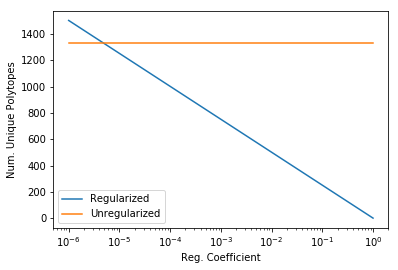

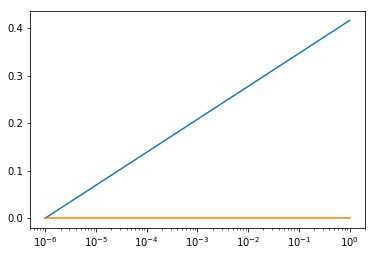

In [6]:
# ==================================
# Display Results
# ==================================

import matplotlib.pyplot as plt

avg = np.average(unique_polytopes)
unique_polytopes = [avg for _ in range(0, len(unique_polytopes))]
avg2 = np.average(errs)
errs = [avg2 for _ in range(0, len(errs))]

import os
cwd = os.getcwd()
plot_dir = cwd + '/plots/'
filename = plot_dir + 'l1_reg' + '.svg'

plt.figure()
ax = plt.axes()
plt.plot(reg_coeffs,unique_polytopes_reg, label='Regularized')
plt.plot(reg_coeffs,unique_polytopes, label='Unregularized')
ax.set_xscale('log')
plt.xlabel('Reg. Coefficient')
plt.ylabel('Num. Unique Polytopes')
plt.legend()
plt.savefig(filename)
plt.show()

plt.figure()
ax = plt.axes()
plt.plot(reg_coeffs,errs_reg)
plt.plot(reg_coeffs,errs)
ax.set_xscale('log')
plt.ylabel('Error_rate')
plt.xlabel('Reg. Coefficient')
plt.show()


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 1036


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


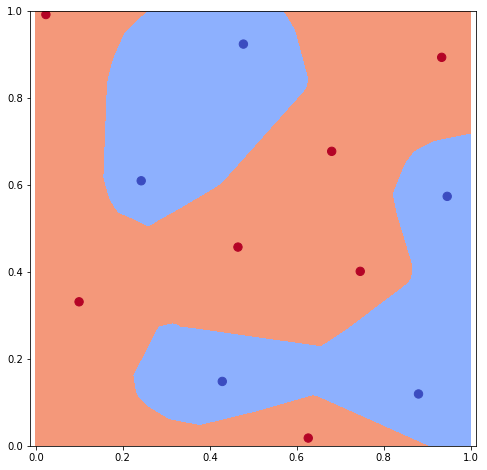

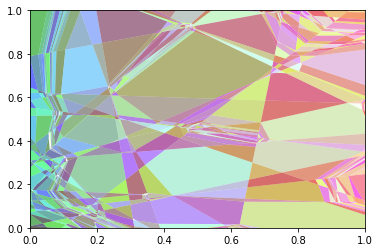

In [7]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN(layer_sizes)
net = network.net

# ==================================
# Train Network
# ==================================

print('===============Training Network============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()

print('error: ', err)

# ==================================
# Gather Polytopes
# ==================================
print('===============Gathering Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))

# ==================================
# Visualize: classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])
plt.show()

# ------------------------------
# Plot Polytopes
# ------------------------------
from _polytope_ import Polytope, from_polytope_dict

polytope_list = []


for relu_configs in unique_relu_configs_list:
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)

ax = plt.axes()
alpha = 0.6
xylim = 1.0

colors = utils.get_spaced_colors(len(polytope_list))
utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()



===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=50, bias=True)
  (2): ReLU()
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=50, bias=True)
  (6): ReLU()
  (7): Linear(in_features=50, out_features=2, bias=True)
)
===============Training Network with Regularization============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 123


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


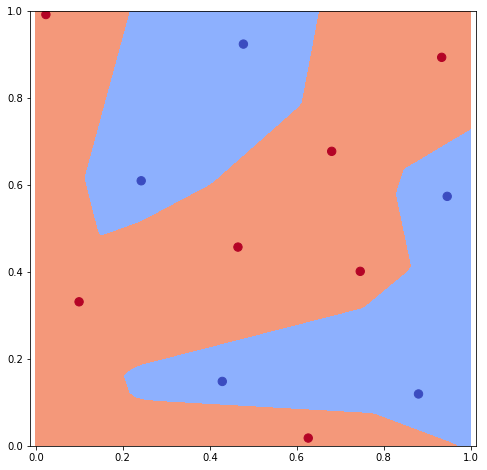

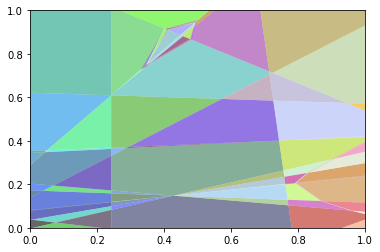

In [8]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN(layer_sizes)
net = network.net

# ==================================
# Train Network
# ==================================

print('===============Training Network with Regularization============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])

    l1_scale = torch.Tensor([0.001])
    l +=  l1_scale*l1_loss(net).view([1])

    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()


print('error: ', err)

# ==================================
# Gather Polytopes
# ==================================
print('===============Gathering Polytopes============')
num_pts = 200
xylim = 1.0

unique_relu_configs_list_reg, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
print('number of polytopes:', len(unique_bin_acts))

# ==================================
# Visualize: classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])
plt.show()

# ------------------------------
# Plot Polytopes Regularized
# ------------------------------
from _polytope_ import Polytope, from_polytope_dict

polytope_list = []


for relu_configs in unique_relu_configs_list_reg:
    polytope_dict = network.compute_polytope_config(relu_configs, True)
    polytope = from_polytope_dict(polytope_dict)
    polytope_list.append(polytope)

ax = plt.axes()
alpha = 0.6
xylim = 1.0

colors = utils.get_spaced_colors(len(polytope_list))
utils.plot_polytopes_2d(polytope_list, colors, alpha, xylim, ax)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.show()